In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50, ResNet50_Weights
from torchsummary import summary
import numpy as np
from model import PositionalEncoding, get_bou_features, find_best_shift, get_img_tokens
from DETR_model import DinoDetrMaskMul
from einops import rearrange
import torchvision.transforms as T
from PIL import Image
from featup.util import norm, unnorm
from featup.plotting import plot_feats
from collections import OrderedDict
import time
from Loader_17 import DAVIS_Rawset, DAVIS_Infer, DAVIS_Dataset
from polygon import RasLoss
import torch.optim as optim
from torch.utils.data import DataLoader
from tenLoader import normalize
import matplotlib.pyplot as plt

In [2]:
rawset = DAVIS_Rawset(is_train=False)

In [3]:
dataset = DAVIS_Dataset(rawset)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)
unshuffle_dataloader = DataLoader(dataset, batch_size=2, shuffle=False)

In [4]:
model = DinoDetrMaskMul(mul_before=True).cuda()
ras_loss = RasLoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main
/work3/s232248/miniconda3/envs/ras/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [5]:
model_name = "DETR_davis_mb"
model_path = f"./model/{model_name}_best.pth"
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [6]:
(
    video_idx,
    frame_idx,
    fir_img,
    fir_sgm,
    pre_img,
    pre_sgm,
    cur_img,
    cur_sgm,
) = next(iter(dataloader))
fir_img.shape, fir_sgm.shape

(torch.Size([2, 3, 224, 224]), torch.Size([2, 224, 224]))

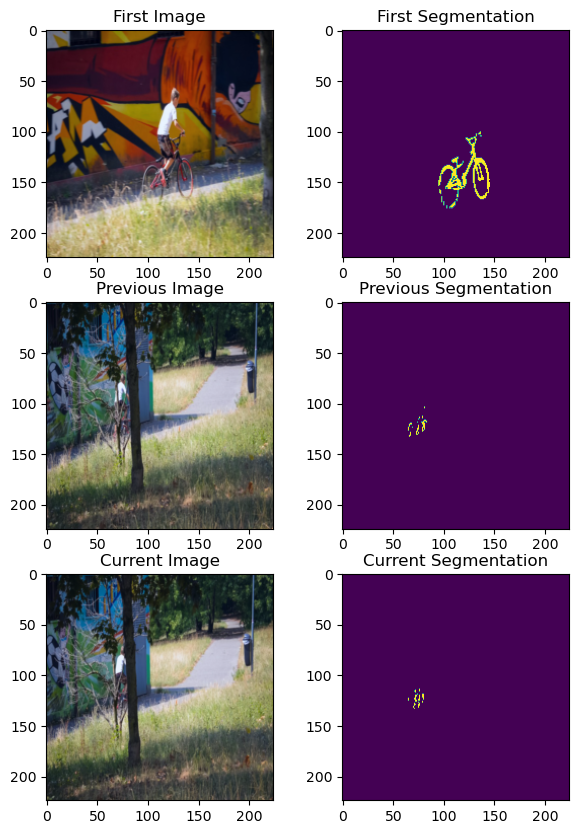

In [7]:
plt.figure(figsize=(7, 10))
# show the first image and its segmentation
plt.subplot(3, 2, 1)
plt.imshow(normalize(fir_img[0]).permute(1, 2, 0))
plt.title("First Image")
plt.subplot(3, 2, 2)
plt.imshow(fir_sgm[0])
plt.title("First Segmentation")
# show the previous image and its segmentation
plt.subplot(3, 2, 3)
plt.imshow(normalize(pre_img[0]).permute(1, 2, 0))
plt.title("Previous Image")
plt.subplot(3, 2, 4)
plt.imshow(pre_sgm[0])
plt.title("Previous Segmentation")
# show the current image and its segmentation
plt.subplot(3, 2, 5)
plt.imshow(normalize(cur_img[0]).permute(1, 2, 0))
plt.title("Current Image")
plt.subplot(3, 2, 6)
plt.imshow(cur_sgm[0])
plt.title("Current Segmentation")
plt.show()

In [8]:
pred_bou = model(
    fir_img.cuda(),
    fir_sgm.cuda(),
    pre_img.cuda(),
    pre_sgm.cuda(),
    cur_img.cuda(),
)
pred_bou.shape

torch.Size([2, 80, 2])

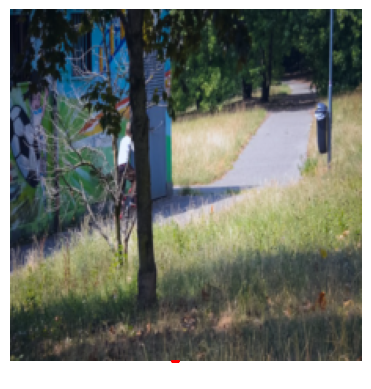

In [9]:
plt.imshow(normalize(cur_img[0].permute(1, 2, 0)))
plt.axis("off")
plt.plot(
    pred_bou[0, :, 0].cpu().detach().numpy(),
    pred_bou[0, :, 1].cpu().detach().numpy(),
    "r",
)
plt.show()

In [10]:
pred_bou.shape, pred_bou

(torch.Size([2, 80, 2]),
 tensor([[[106.0167, 223.9920],
          [105.0939, 223.9802],
          [106.8185, 223.9719],
          [104.5336, 223.9703],
          [104.4214, 223.9741],
          [105.9078, 223.9766],
          [104.2533, 223.9834],
          [105.0018, 223.9725],
          [105.9735, 223.9852],
          [105.8246, 223.9905],
          [104.7884, 223.9855],
          [104.9980, 223.9698],
          [104.0266, 223.9749],
          [105.4083, 223.9738],
          [105.0855, 223.9849],
          [106.5661, 223.9840],
          [103.4883, 223.9773],
          [105.5016, 223.9821],
          [105.5659, 223.9821],
          [102.7122, 223.9727],
          [106.0819, 223.9821],
          [104.9979, 223.9803],
          [106.4094, 223.9825],
          [106.1791, 223.9848],
          [103.9071, 223.9781],
          [105.7919, 223.9884],
          [105.3953, 223.9752],
          [106.8950, 223.9793],
          [105.4591, 223.9860],
          [104.7501, 223.9904],
          [104.

In [11]:
pred_bou_shift = torch.roll(pred_bou, 1, 1)
pred_bou_offset = torch.square(pred_bou - pred_bou_shift)
pred_edges = torch.sum(pred_bou_offset, dim=2)
pred_edges = torch.sqrt(pred_edges)
np_edges = pred_edges.int().cpu().detach().numpy()
# count the number of edges that are larger than 10
np.sum(np_edges > 10)



14

In [12]:
def get_edges(pred_bou: torch.Tensor) -> torch.Tensor:
    pred_bou_shift = torch.roll(pred_bou, 1, 1)
    pred_bou_offset = torch.square(pred_bou - pred_bou_shift)
    pred_edges = torch.sum(pred_bou_offset, dim=2)
    pred_edges = torch.sqrt(pred_edges)
    return pred_edges
pred_edges = get_edges(pred_bou)
pred_edges.shape, pred_edges

(torch.Size([2, 80]),
 tensor([[1.3924e+00, 9.2280e-01, 1.7246e+00, 2.2849e+00, 1.1227e-01, 1.4863e+00,
          1.6545e+00, 7.4861e-01, 9.7181e-01, 1.4904e-01, 1.0362e+00, 2.1021e-01,
          9.7145e-01, 1.3817e+00, 3.2293e-01, 1.4806e+00, 3.0778e+00, 2.0133e+00,
          6.4301e-02, 2.8538e+00, 3.3698e+00, 1.0840e+00, 1.4114e+00, 2.3030e-01,
          2.2720e+00, 1.8849e+00, 3.9689e-01, 1.4997e+00, 1.4359e+00, 7.0901e-01,
          1.8515e-01, 2.0258e+00, 1.1366e+00, 4.0919e-01, 7.7537e-01, 2.3293e+00,
          2.6556e-01, 7.6888e-02, 4.6258e-02, 1.1659e+00, 8.3234e-01, 1.5777e-01,
          2.8602e-01, 3.7650e-01, 1.3844e+00, 2.4283e+00, 2.5137e+00, 1.5540e+00,
          1.8756e-01, 7.3216e-02, 2.1417e+00, 2.5891e+00, 1.0841e+00, 9.2579e-01,
          5.1719e-01, 1.9970e+00, 4.0036e-01, 7.0262e-01, 5.3311e-01, 5.2785e-01,
          1.1572e+00, 3.4721e-01, 9.6934e-01, 1.6062e+00, 4.0547e-01, 1.0642e+00,
          1.8781e-01, 9.7690e-01, 1.1121e+00, 6.5565e-01, 1.9019e+00, 4.0931

In [13]:
pred_edge_mean = torch.mean(pred_edges, 1, keepdim=True)
pred_edge_mean.shape

torch.Size([2, 1])

In [14]:
pred_edge_offset = pred_edges - pred_edge_mean
pred_edge_offset.shape, pred_edge_offset

(torch.Size([2, 80]),
 tensor([[ 2.8725e-01, -1.8238e-01,  6.1940e-01,  1.1797e+00, -9.9291e-01,
           3.8114e-01,  5.4931e-01, -3.5656e-01, -1.3337e-01, -9.5614e-01,
          -6.8950e-02, -8.9496e-01, -1.3373e-01,  2.7654e-01, -7.8225e-01,
           3.7539e-01,  1.9726e+00,  9.0809e-01, -1.0409e+00,  1.7486e+00,
           2.2646e+00, -2.1186e-02,  3.0625e-01, -8.7487e-01,  1.1668e+00,
           7.7969e-01, -7.0829e-01,  3.9452e-01,  3.3072e-01, -3.9617e-01,
          -9.2003e-01,  9.2066e-01,  3.1440e-02, -6.9599e-01, -3.2981e-01,
           1.2242e+00, -8.3962e-01, -1.0283e+00, -1.0589e+00,  6.0726e-02,
          -2.7284e-01, -9.4741e-01, -8.1916e-01, -7.2868e-01,  2.7918e-01,
           1.3231e+00,  1.4085e+00,  4.4885e-01, -9.1762e-01, -1.0320e+00,
           1.0365e+00,  1.4839e+00, -2.1110e-02, -1.7939e-01, -5.8799e-01,
           8.9181e-01, -7.0481e-01, -4.0256e-01, -5.7207e-01, -5.7733e-01,
           5.2029e-02, -7.5797e-01, -1.3583e-01,  5.0099e-01, -6.9971e-01,
   

In [15]:
torch.square(pred_edge_offset).shape

torch.Size([2, 80])

In [16]:
pred_edge_deviation = torch.mean(
    torch.square(pred_edge_offset),
    1,
    keepdim=False,
)
pred_edge_deviation.shape

torch.Size([2])

In [17]:
def deviation_loss(pred_bou: torch.Tensor, max_coord=224) -> torch.Tensor:
    pred_bou = pred_bou / max_coord
    pred_edges = get_edges(pred_bou)
    pred_edge_mean = torch.mean(pred_edges, 1, keepdim=True)
    pred_edge_offset = pred_edges - pred_edge_mean
    pred_edge_deviation = torch.mean(
        torch.square(pred_edge_offset),
        1,
        keepdim=False,
    )
    pred_edge_deviation = torch.sqrt(pred_edge_deviation)
    return pred_edge_deviation.mean()
pred_edge_deviation = deviation_loss(pred_bou)
pred_edge_deviation

tensor(0.0402, device='cuda:0', grad_fn=<MeanBackward0>)

In [19]:
def total_len_loss(pred_bou: torch.Tensor, max_coord=224) -> torch.Tensor:
    pred_bou = pred_bou / max_coord
    pred_edges = get_edges(pred_bou)
    return pred_edges.mean()

In [20]:
ras_loss(pred_bou, cur_sgm.cuda()), deviation_loss(pred_bou), total_len_loss(pred_bou)

(tensor(0.4052, device='cuda:0', grad_fn=<RsubBackward1>),
 tensor(0.0402, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.0232, device='cuda:0', grad_fn=<MeanBackward0>))